In this notebook I'll check whether I can reproduce LGal spectra if I feed in the same SFH and ZH to `provabgs`. This is to identify if there are any discrepancies between the SPS model of LGal and `provabgs`

In [1]:
import os
import numpy as np 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
from gqp_mc import data as Data

In [3]:
from provabgs import models as Models
from provabgs import infer as Infer

# read `LGal` spectra

In [4]:
spec_nonoise, meta = Data.Spectra(sim='lgal', noise='none')
spec_noise, _ = Data.Spectra(sim='lgal', noise='bgs')
photo, _ = Data.Photometry(sim='lgal', noise='legacy')

In [5]:
igal = 13

(-1.0, 5.0)

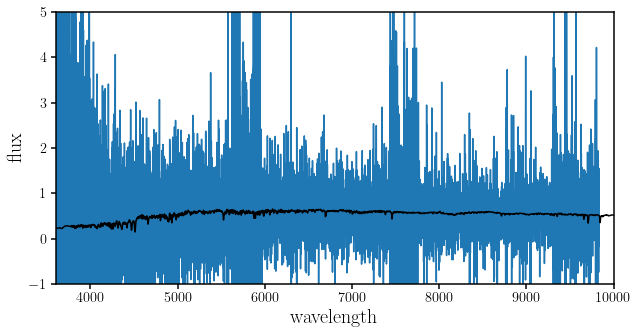

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-1, 5)

# setup `provabgs`

In [7]:
m_nmf = Models.NMF(burst=True, iso_unc=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index, iso_unc0, iso_unc1, iso_unc2


# Lets try to reproduce the LGal spectra with `provabgs`

In [11]:
# bestfit from S2
theta_bf = np.array([ 9.09788033e+00,  1.68572232e-01,  8.72346674e-02,  6.84204795e-01,
        5.99883059e-02,  9.63178599e-02,  9.44794564e-01,  7.84027029e-05,
        2.89134312e-03,  2.59285767e+00,  7.55391175e-01, -8.97111831e-01, 0., 0., 0.])

Text(0, 0.5, 'ZH')

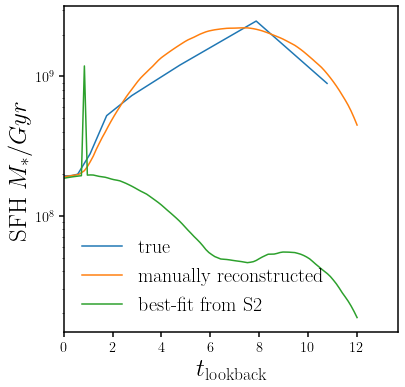

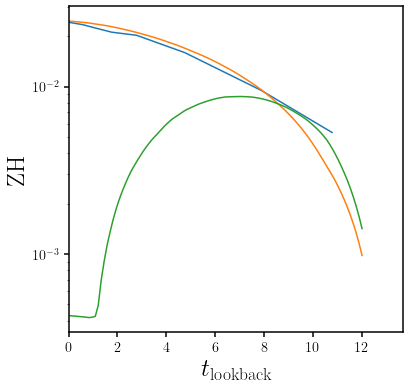

In [16]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], (meta['sfh_disk'][igal] + meta['sfh_bulge'][igal])/meta['dt'][igal], label='true')

theta_i = np.array([
    meta['logM_total'][igal], 
    0.5, 
    0.35, 
    0.05,
    0.1,
    0., 
    0., 
    0, 
    0,
    meta['tau_bc'][igal], 
    meta['tau_ism'][igal], 
    0.,
    0., 0., 0.
])

t, sfh = m_nmf.SFH(theta_i, zred=meta['redshift'][igal])
sub.plot(t, sfh, label='manually reconstructed')
t, sfh = m_nmf.SFH(theta_bf, zred=meta['redshift'][igal])
sub.plot(t, sfh, label='best-fit from S2')
sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylabel('SFH $M_*/Gyr$', fontsize=25)
sub.set_yscale('log')

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], 
         (meta['Z_disk'][igal] * meta['sfh_disk'][igal] + meta['Z_bulge'][igal] * meta['sfh_bulge'][igal])/(meta['sfh_disk'][igal] + meta['sfh_bulge'][igal]), 
        label='true')

theta_i[7] = 4.5e-3
theta_i[8] = 2e-3#7.84027029e-05#1e-2# 2.89134312e-03
t, zh = m_nmf.ZH(theta_i, zred=meta['redshift'][igal])
sub.plot(t, zh, label='manually reconstructed')
t, zh = m_nmf.ZH(theta_bf, zred=meta['redshift'][igal])
sub.plot(t, zh, label='best-fit from S2')
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_yscale('log')
sub.set_ylabel('ZH', fontsize=25)

In [17]:
theta_true = theta_i.copy()
theta_true[0] = meta['logM_fiber'][igal]

/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/Users/chahah/projects/provabgs/src/provabgs/models.py:934: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])


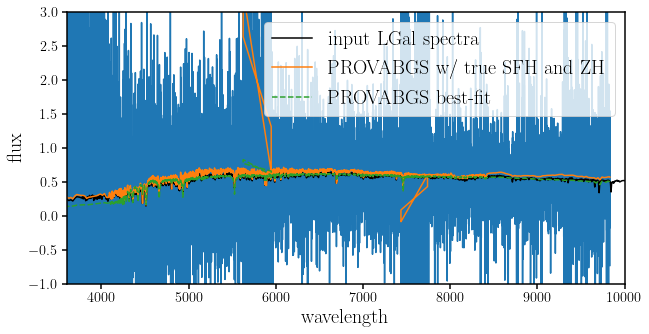

In [18]:
w, f = m_nmf.sed(theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
w_bf, f_bf = m_nmf.sed(theta_bf, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k', label='input LGal spectra')
sub.plot(w, f, label='PROVABGS w/ true SFH and ZH')
sub.plot(w_bf, f_bf, ls='--', label='PROVABGS best-fit')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-1, 3)
sub.legend(loc='upper right', fontsize=20, frameon=True)

In [19]:
np.sum((spec_noise['flux'][igal,:] - f)**2 * spec_noise['ivar'][igal])

9116.390505389456

In [20]:
np.sum((spec_noise['flux'][igal,:] - np.interp(spec_noise['wave'], spec_nonoise['wave'], spec_nonoise['flux'][igal]))**2 * spec_noise['ivar'][igal])

8789.64985551564

**The $\chi^2$ is lower for the best-fit than `provabgs` run with the true SFH and ZH!** Interesting. The best-fit from the S2 test actually matches the noiseless spectra quite well and has a higher likelihood.

# Lets check the inference
Lets run a chain without initializing the walkers and a chain with initializing the walkers

In [34]:
# set prior
prior = Infer.load_priors([
    Infer.UniformPrior(8., 12., label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed'),     # uniform priors on dust_index
    Infer.GaussianPrior(0., 4.3**2, label='sed'),
    Infer.GaussianPrior(0., 2.5**2, label='sed'),
    Infer.GaussianPrior(0., 1.7**2, label='sed')
])

desi_mcmc = Infer.desiMCMC(model=m_nmf, prior=prior)

# run MCMC
zeus_chain0 = desi_mcmc.run(
    wave_obs=spec_noise['wave'],
    flux_obs=spec_noise['flux'][igal,:],
    flux_ivar_obs=spec_noise['ivar'][igal,:],
    zred=meta['redshift'][igal],
    vdisp=0., # 25 is roughly the median of the L-Galaxies mock
    sampler='zeus',
    nwalkers=30,
    burnin=0,
    opt_maxiter=2000,
    niter=5000,
    progress=True,
    debug=True)

--- initializing the walkers ---


/Users/chahah/projects/provabgs/src/provabgs/models.py:934: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/5000 [00:00<?, ?it/s]

initial theta = [9.32804787638851, 0.9988387297533272, 0.9999989050815126, 0.15067936823969263, 0.08400073106548883, 8.169775781123128, 0.002895428255861414, 0.0012857989517407221, 0.7132678062889464, 1.4964321704645789, -0.006625073666621916, 10.133191982324536, -0.3038705305173056, -0.7227142287983455]
log Posterior(theta0) = -4450.043404
--- running MCMC ---


Sampling progress : 100%|██████████| 5000/5000 [38:26<00:00,  2.17it/s] 

bestfit theta = [9.078215724052727, 0.01253628444611421, 0.14467171617875466, 0.6476539173577723, 0.19513808201735874, 0.07424650995014317, 0.9541143563940575, 9.065512998778874e-05, 0.0031040106736179, 2.671180104963579, 0.6437150734504294, -1.2238596551294163, 2.077625088284168, 0.07525728598750037, -0.9367468136150745]
log Posterior = -4401.092444
Model.sed: redshift = 0.136576
Model.sed: ssp lum [ 1762.08446503  1892.43325486  1835.21645722 ... 57178.98742576
 57274.62660015 57339.40795505]


In [36]:
theta_start = theta_i.copy()
theta_start[0] = meta['logM_fiber'][igal]

In [38]:
# run MCMC
zeus_chain1 = desi_mcmc.run(
    wave_obs=spec_noise['wave'],
    flux_obs=spec_noise['flux'][igal,:],
    flux_ivar_obs=spec_noise['ivar'][igal,:],
    zred=meta['redshift'][igal],
    theta_start=prior.untransform(theta_start),
    vdisp=0., # 25 is roughly the median of the L-Galaxies mock
    sampler='zeus',
    nwalkers=30,
    burnin=0,
    opt_maxiter=2000,
    niter=5000,
    progress=True,
    debug=True)

/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 30 walkers...
/Users/chahah/projects/provabgs/src/provabgs/models.py:934: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Sampling progress :   0%|          | 0/5000 [00:00<?, ?it/s]

--- initializing the walkers ---
initial theta = [9.448093279956131, 0.5, 0.30000000000000004, 0.6666666666666667, 0.0, 0.0, 0.0045, 0.002, 0.5064289210369245, 0.2716541776628665, 0.0, 0.0, 0.0, 0.0]
log Posterior(theta0) = -4563.857602
--- running MCMC ---


Sampling progress : 100%|██████████| 5000/5000 [1:18:09<00:00,  1.07it/s]

bestfit theta = [9.158372913806554, 0.07377814862011334, 0.06325900797046516, 0.445468163072846, 0.41749468033657555, 0.06395263974165719, 0.9341772558213564, 0.00010732686285252616, 0.0021981449109618064, 2.5537291139116407, 0.6433429447836522, -1.024498097807031, 2.6743971313027197, 1.2133175762082125, 0.025378014393103027]
log Posterior = -4401.230154
Model.sed: redshift = 0.136576
Model.sed: ssp lum [ 3501.34072126  3664.85243259  3486.62273758 ... 57755.83353287
 57788.06340082 57823.27628547]


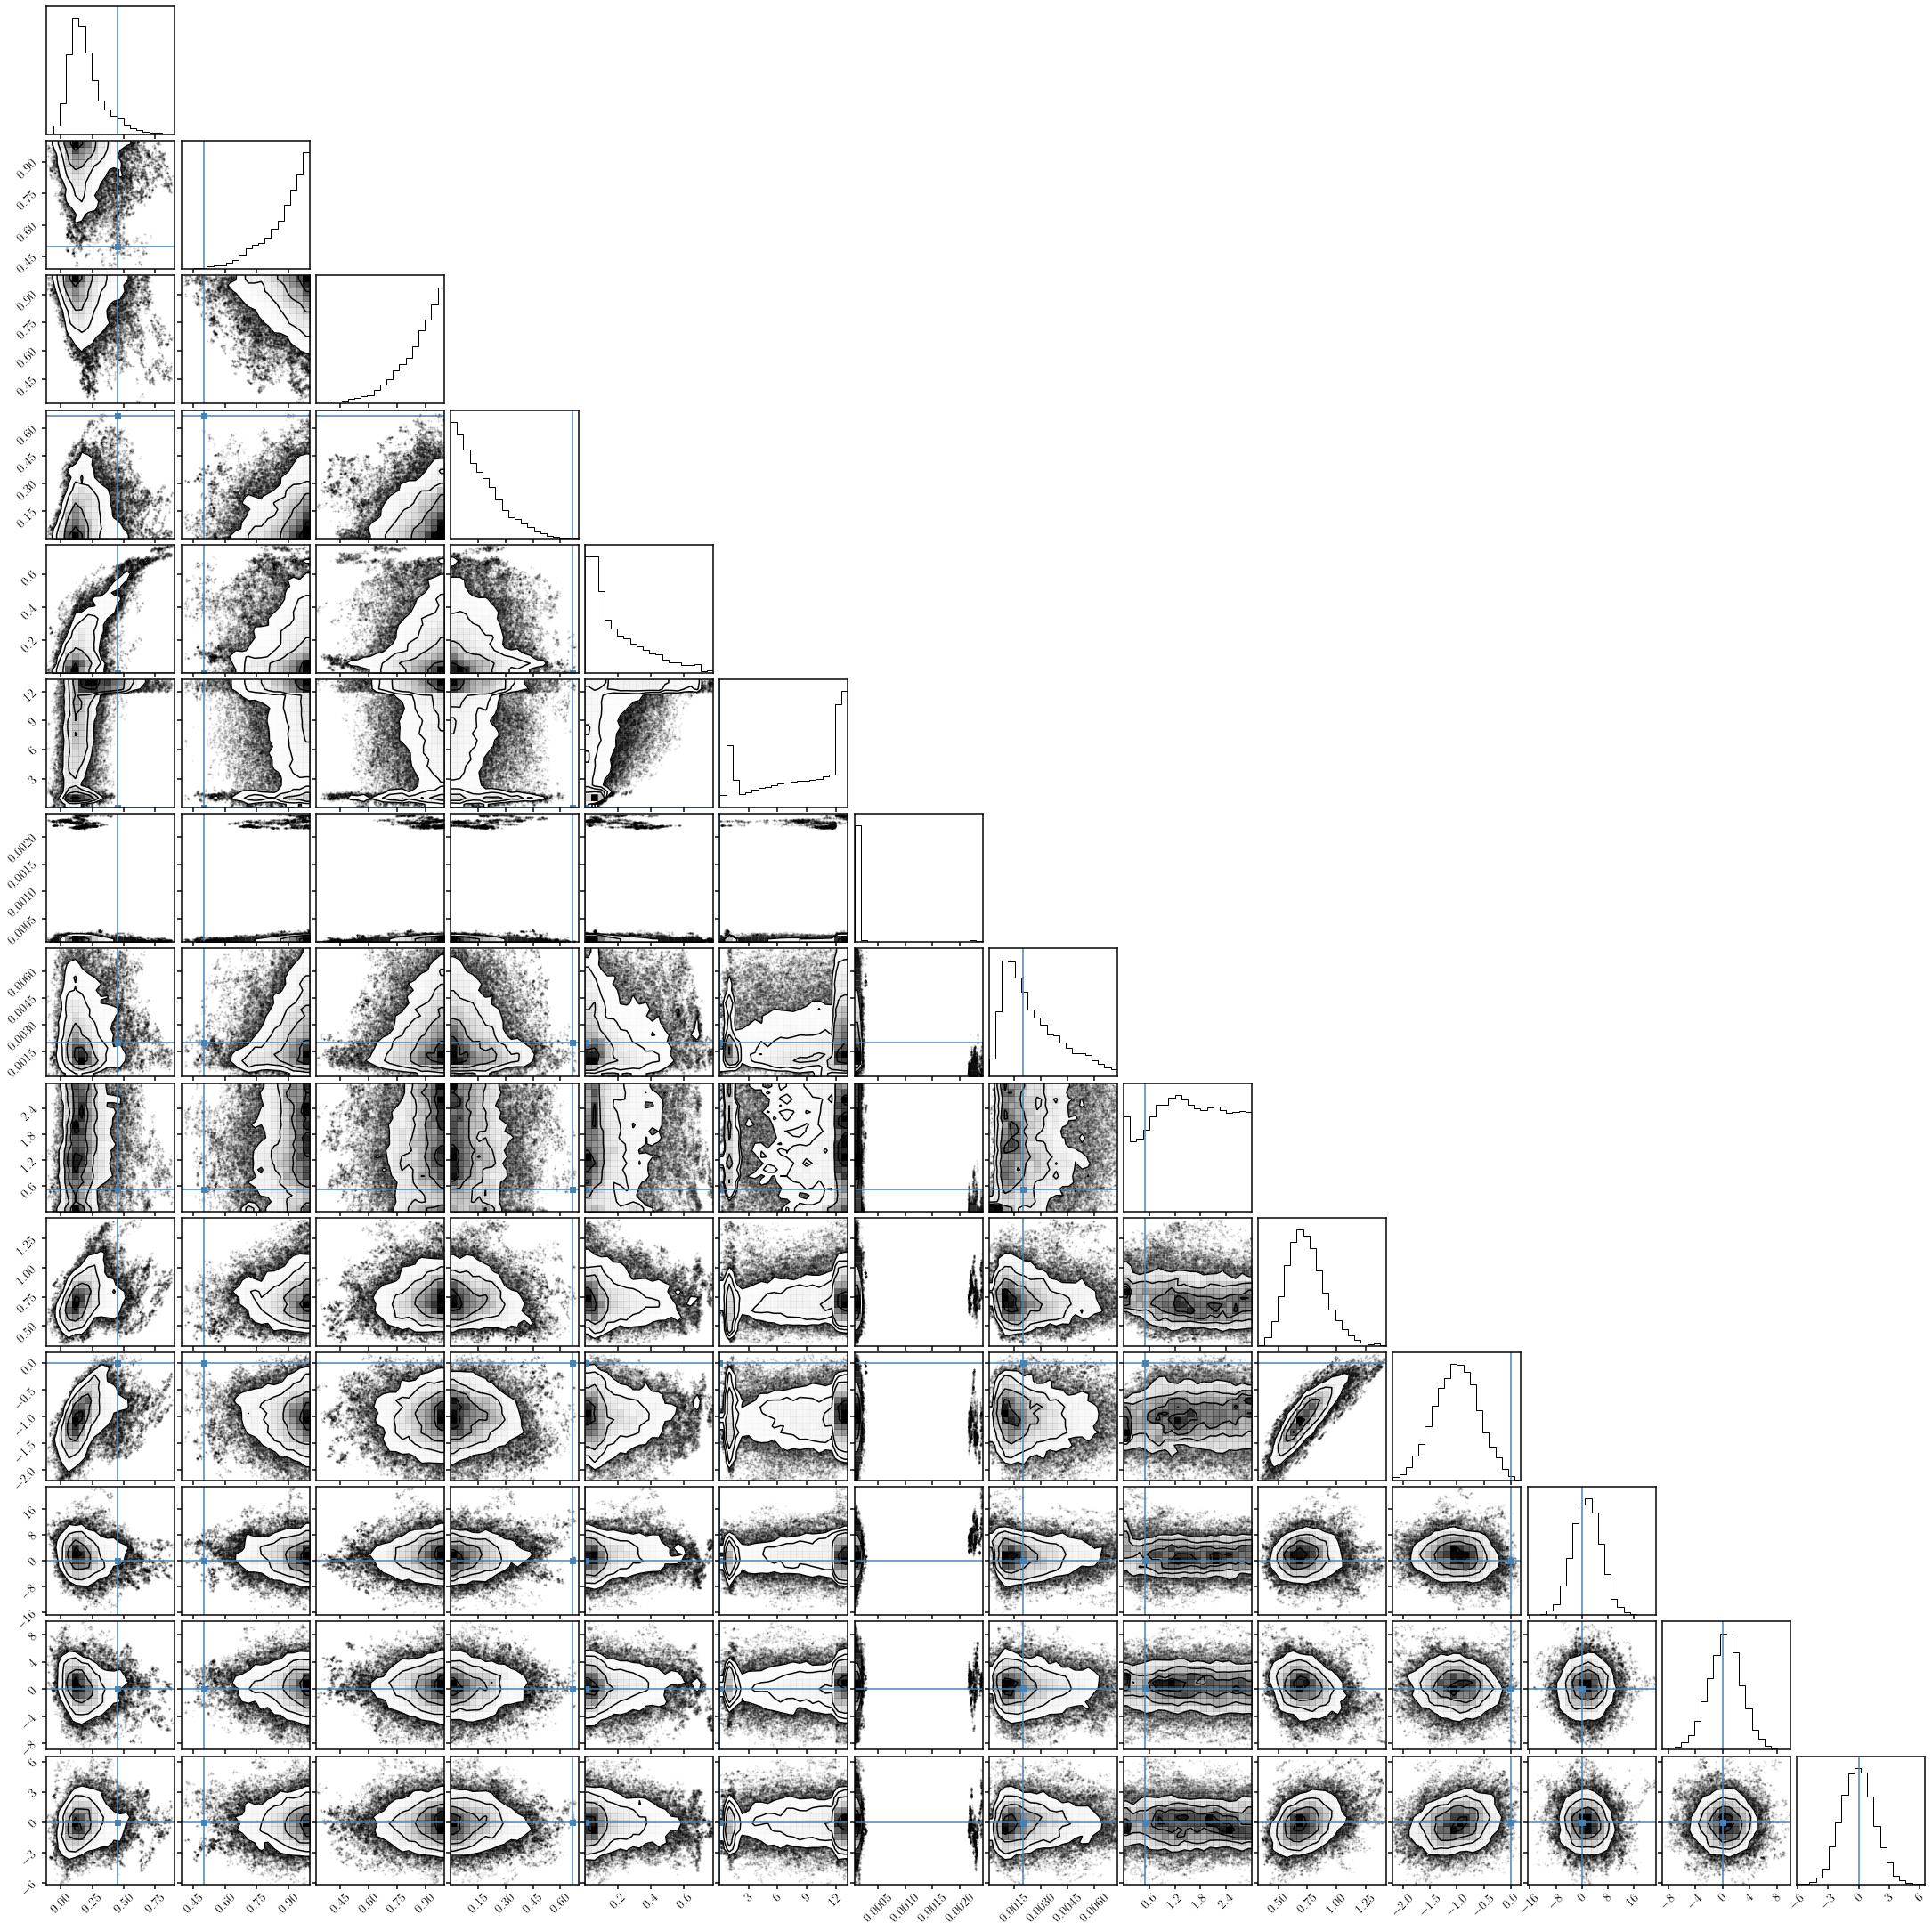

In [39]:
_ = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain0['mcmc_chain'][1000:,:,:])), truths=prior.untransform(theta_start))

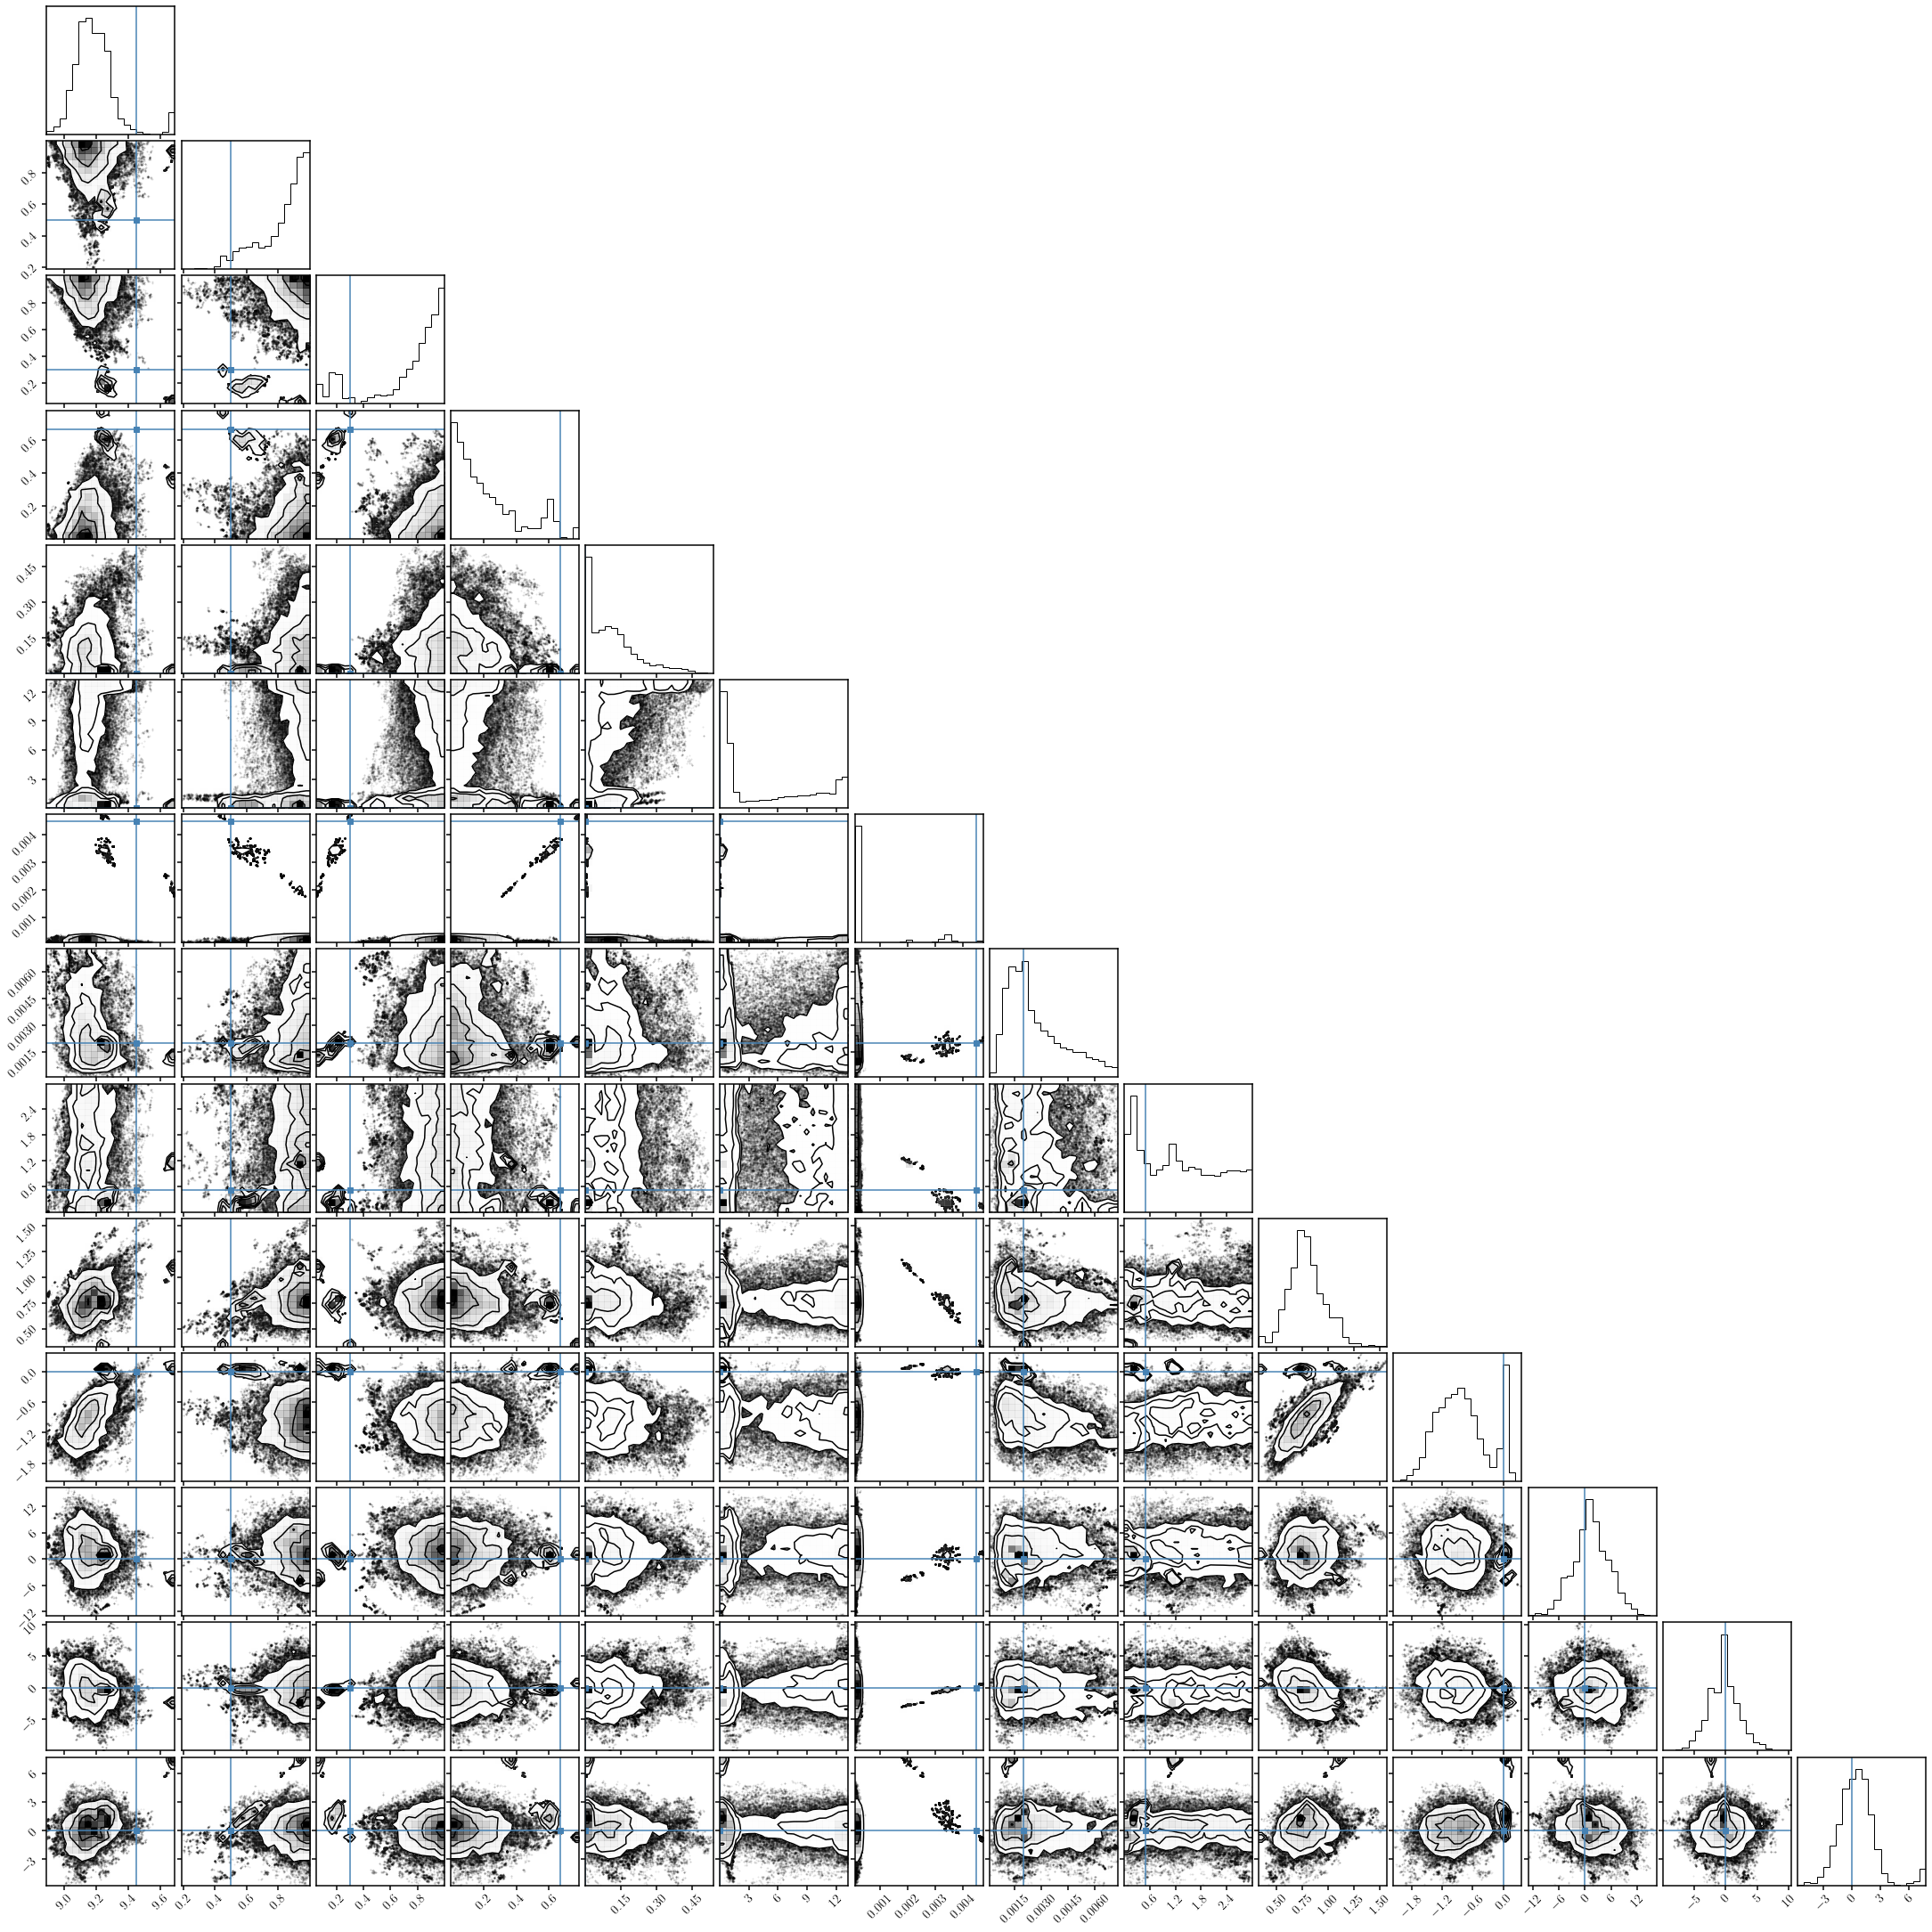

In [40]:
_ = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain1['mcmc_chain'][1000:,:,:])), truths=prior.untransform(theta_start))

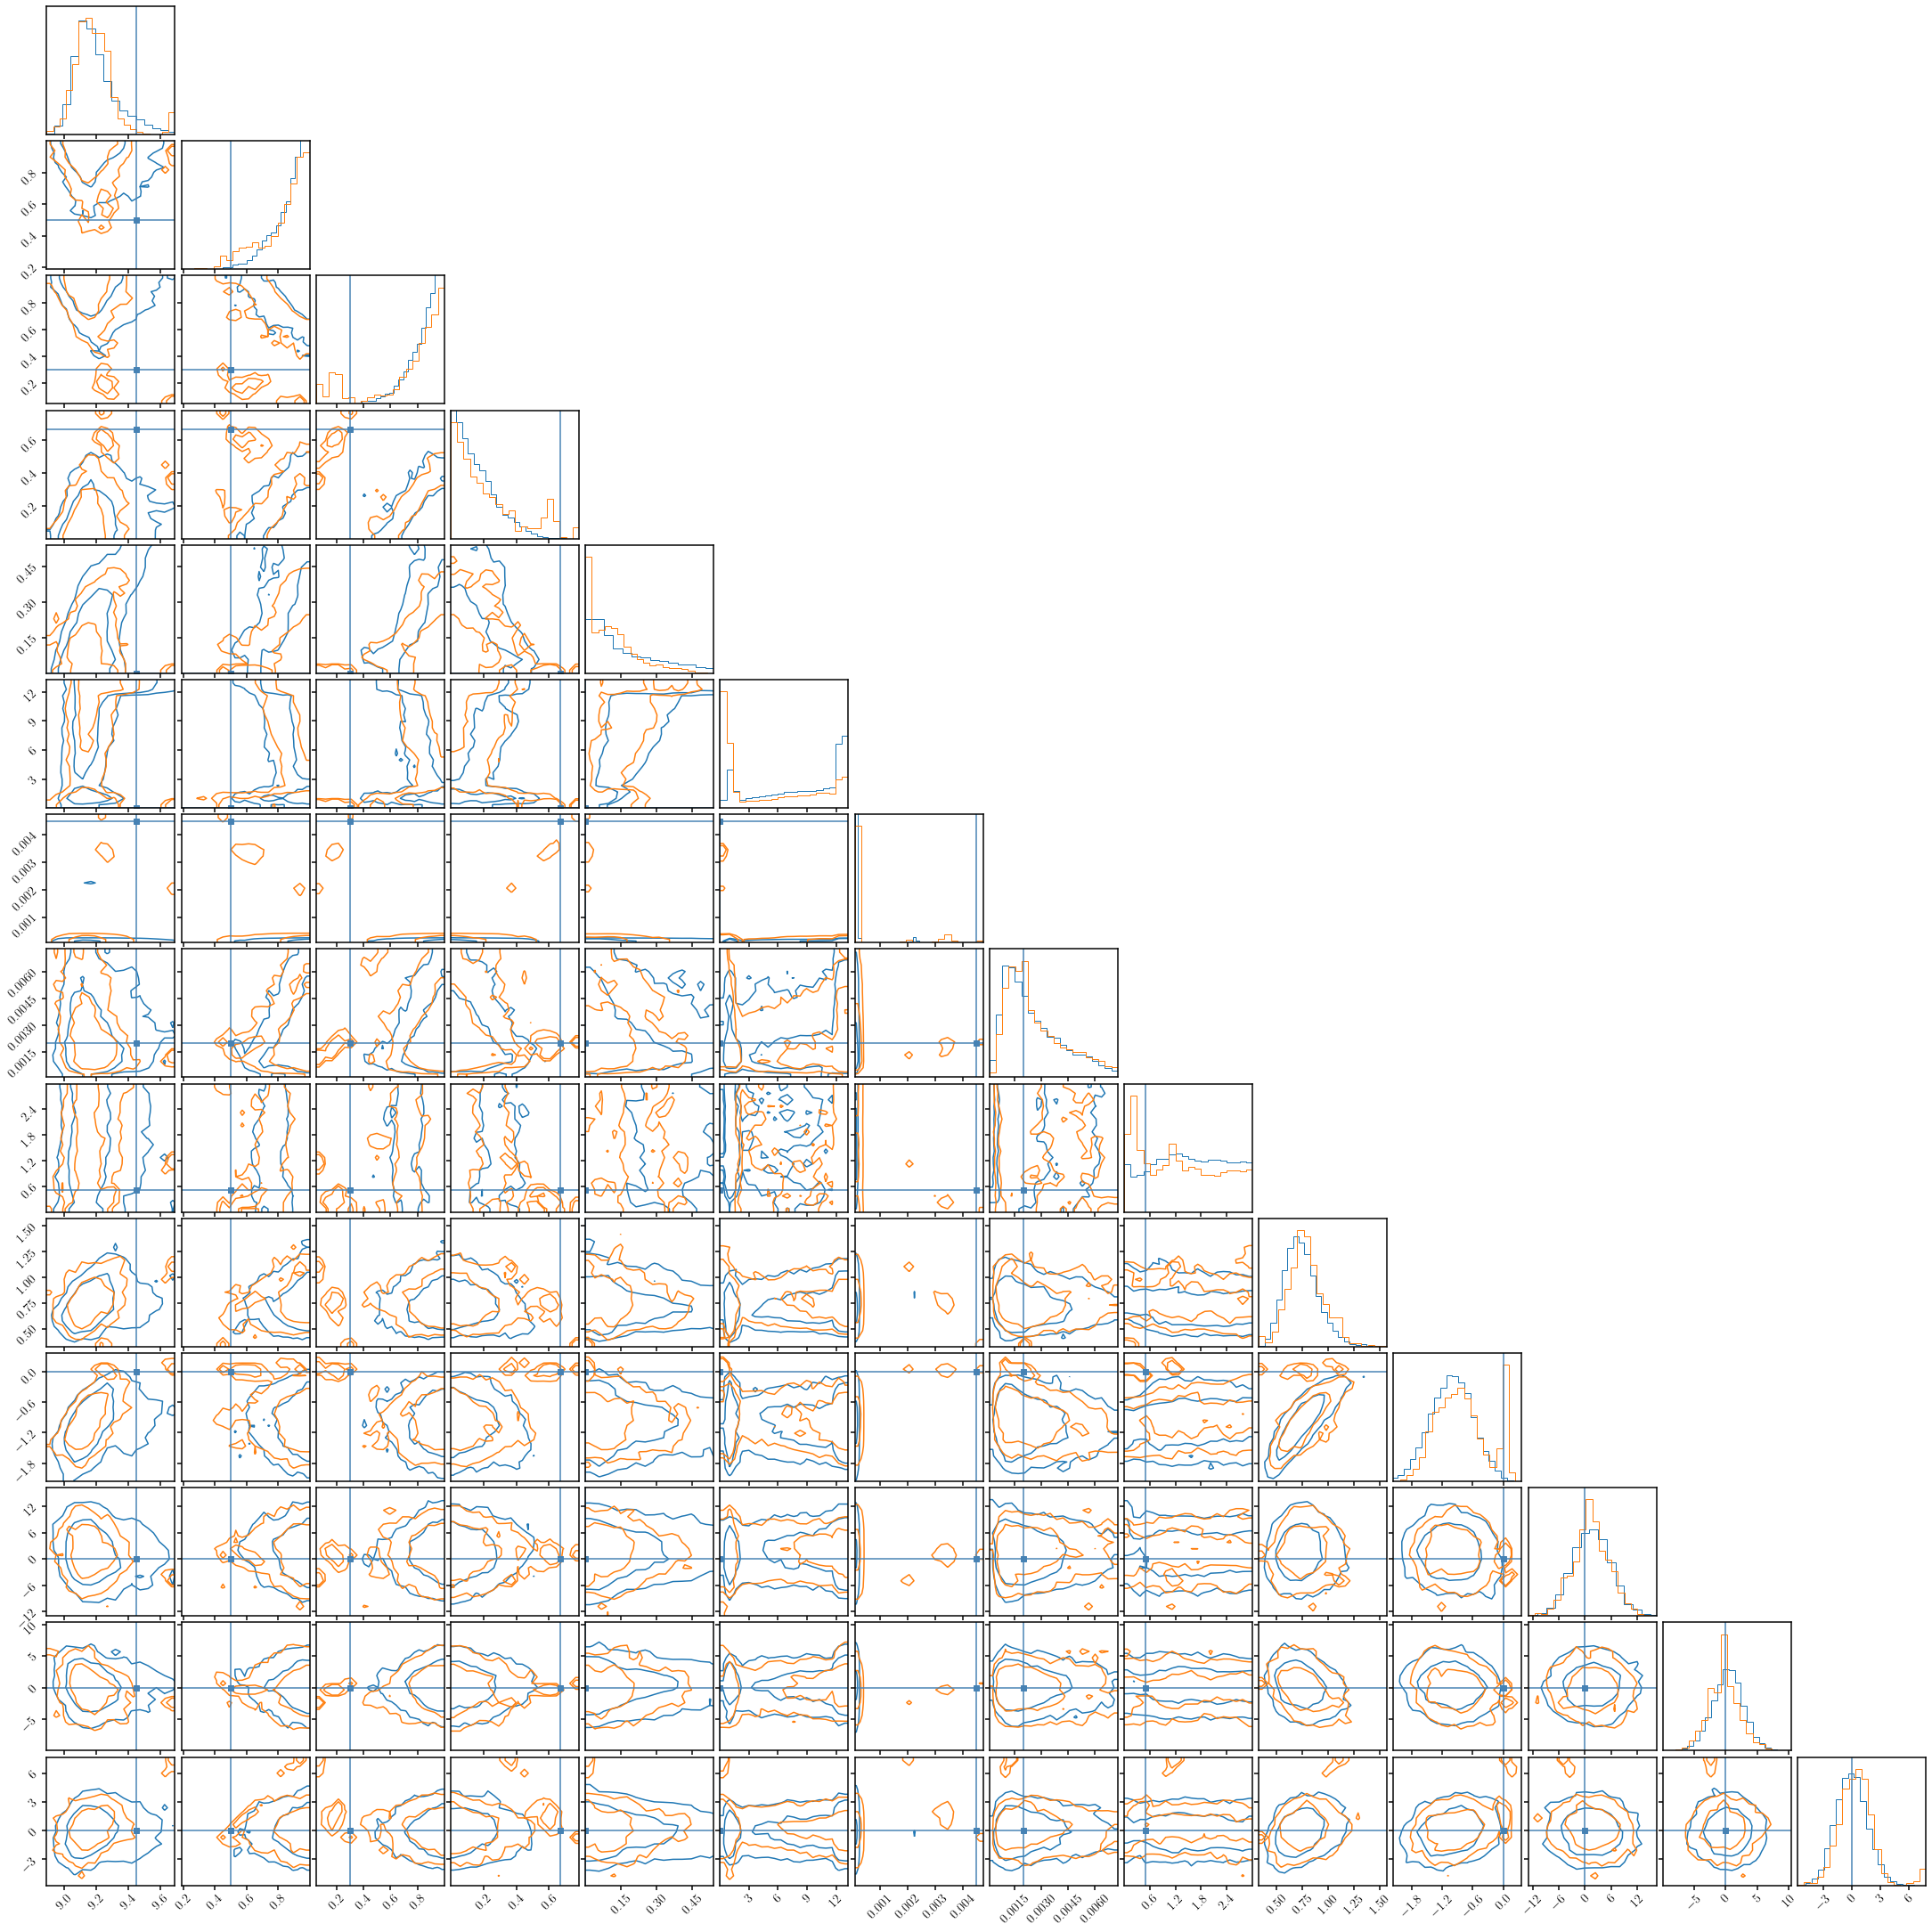

In [42]:
fig = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain0['mcmc_chain'][1000:,:,:])), 
                 levels=[0.68, 0.95], color='C0', hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)

_ = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain1['mcmc_chain'][1000:,:,:])), 
                   truths=prior.untransform(theta_start),
                   levels=[0.68, 0.95], color='C1', hist_kwargs={'density': True},
                   plot_datapoints=False, plot_density=False, fig=fig)

The initialization of the walkers don't seem to matter as much as I thought, but first 

## Lets compare the derived galaxy properties

In [43]:
logMstar_true = theta_start[0]
logSSFR_true = np.log10(m_nmf.avgSFR(theta_start, meta['redshift'][igal], dt=1.0)) - logMstar_true
logZ_MW_true = np.log10(m_nmf.Z_MW(theta_start, m_nmf.cosmo.age(meta['redshift'][igal]).value))
prop_true = np.array([logMstar_true, logSSFR_true, logZ_MW_true])

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [67]:
flat_chain0 = desi_mcmc._flatten_chain(zeus_chain0['mcmc_chain'][1000:,:,:])
logMstar_inf0 = flat_chain0[:,0]
logSSFR_inf0 = np.log10(m_nmf.avgSFR(flat_chain0, meta['redshift'][igal], dt=1.0)) - flat_chain0[:,0]
logZ_MW_inf0 = np.log10(m_nmf.Z_MW(flat_chain0, m_nmf.cosmo.age(meta['redshift'][igal]).value))
prop_inf0 = np.vstack([logMstar_inf0, logSSFR_inf0, logZ_MW_inf0]).T

In [68]:
flat_chain1 = desi_mcmc._flatten_chain(zeus_chain1['mcmc_chain'][1000:,:,:])
logMstar_inf1 = flat_chain1[:,0]
logSSFR_inf1 = np.log10(m_nmf.avgSFR(flat_chain1, meta['redshift'][igal], dt=1.0)) - flat_chain1[:,0]
logZ_MW_inf1 = np.log10(m_nmf.Z_MW(flat_chain1, m_nmf.cosmo.age(meta['redshift'][igal]).value))
prop_inf1 = np.vstack([logMstar_inf1, logSSFR_inf1, logZ_MW_inf1]).T

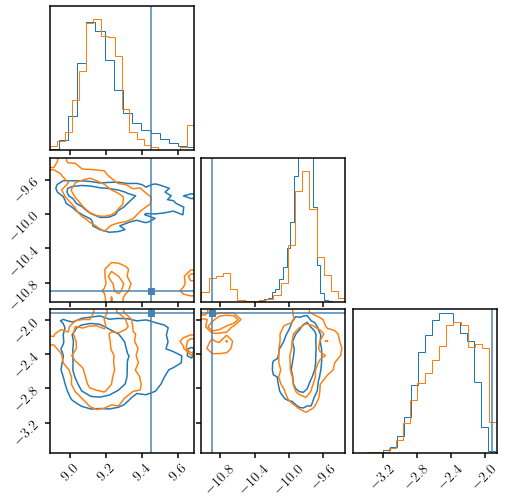

In [69]:
fig = DFM.corner(prop_inf0, 
                 levels=[0.68, 0.95], color='C0', hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)

_ = DFM.corner(prop_inf1, 
               truths=prop_true,
               levels=[0.68, 0.95], color='C1', hist_kwargs={'density': True},
               plot_datapoints=False, plot_density=False, fig=fig)

Text(0, 0.5, 'ZH')

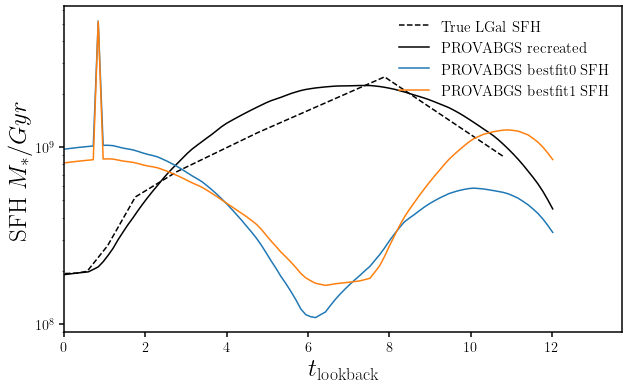

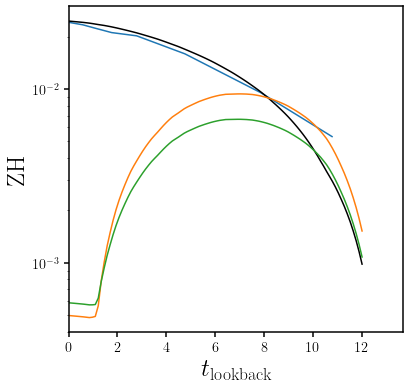

In [73]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], (meta['sfh_disk'][igal] + meta['sfh_bulge'][igal])/meta['dt'][igal], c='k', ls='--',
         label='True LGal SFH')

t, sfh = m_nmf.SFH(theta_true, zred=meta['redshift'][igal])
sub.plot(t, 10**(meta['logM_total'][igal]-meta['logM_fiber'][igal]) * sfh, c='k', 
        label='PROVABGS recreated')

t, sfh = m_nmf.SFH(zeus_chain0['theta_bestfit'], zred=meta['redshift'][igal])
sub.plot(t, 10**(meta['logM_total'][igal]-meta['logM_fiber'][igal]) * sfh, c='C0', 
        label='PROVABGS bestfit0 SFH')
t, sfh = m_nmf.SFH(zeus_chain1['theta_bestfit'], zred=meta['redshift'][igal])
sub.plot(t, 10**(meta['logM_total'][igal]-meta['logM_fiber'][igal]) * sfh, c='C1', 
        label='PROVABGS bestfit1 SFH')
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylabel('SFH $M_*/Gyr$', fontsize=25)
sub.set_yscale('log')
sub.legend(loc='upper right', fontsize=15)


fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], 
         (meta['Z_disk'][igal] * meta['sfh_disk'][igal] + meta['Z_bulge'][igal] * meta['sfh_bulge'][igal])/(meta['sfh_disk'][igal] + meta['sfh_bulge'][igal]), 
        label='true')

t, zh = m_nmf.ZH(theta_true, zred=meta['redshift'][igal])
sub.plot(t, zh, c='k', label='manually reconstructed')
t, zh = m_nmf.ZH(zeus_chain0['theta_bestfit'], zred=meta['redshift'][igal])
sub.plot(t, zh)
t, zh = m_nmf.ZH(zeus_chain1['theta_bestfit'], zred=meta['redshift'][igal])
sub.plot(t, zh)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_yscale('log')
sub.set_ylabel('ZH', fontsize=25)

Once bursts are introduced there are so many degeneracies...

/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])


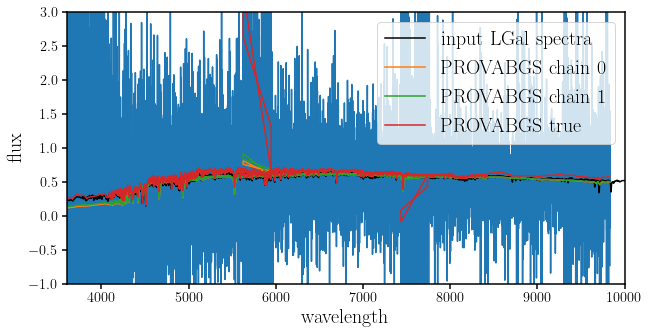

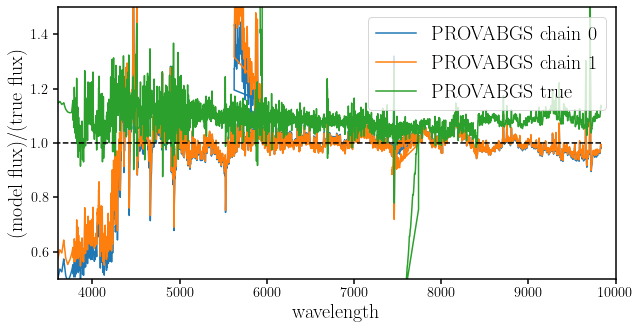

In [109]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k', label='input LGal spectra')
sub.plot(zeus_chain0['wavelength_obs'], zeus_chain0['flux_spec_model'], label='PROVABGS chain 0')
sub.plot(zeus_chain1['wavelength_obs'], zeus_chain1['flux_spec_model'], label='PROVABGS chain 1')

w, f = m_nmf.sed(theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
sub.plot(w, f, label='PROVABGS true')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-1, 3)
sub.legend(loc='upper right', fontsize=20, frameon=True)

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
#sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
#sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k', label='input LGal spectra')
sub.plot(zeus_chain0['wavelength_obs'], zeus_chain0['flux_spec_model']/np.interp(zeus_chain0['wavelength_obs'], spec_nonoise['wave'], spec_nonoise['flux'][igal,:]), label='PROVABGS chain 0')
sub.plot(zeus_chain1['wavelength_obs'], zeus_chain1['flux_spec_model']/np.interp(zeus_chain1['wavelength_obs'], spec_nonoise['wave'], spec_nonoise['flux'][igal,:]), label='PROVABGS chain 1')

w, f = m_nmf.sed(theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
sub.plot(w, f/np.interp(w, spec_nonoise['wave'], spec_nonoise['flux'][igal,:]), label='PROVABGS true')
sub.plot(w, np.ones(len(w)), c='k', ls='--')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('(model flux)/(true flux)', fontsize=20)
sub.set_ylim(0.5, 1.5)
sub.legend(loc='upper right', fontsize=20, frameon=True)

In [83]:
# set prior
new_prior = Infer.load_priors([
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed'),     # uniform priors on dust_index
    Infer.GaussianPrior(0., 4.3**2, label='sed'),
    Infer.GaussianPrior(0., 2.5**2, label='sed'),
    Infer.GaussianPrior(0., 1.7**2, label='sed')
])


def lnpost(tt): 
    lp = new_prior.lnPrior(tt)
    if not np.isfinite(lp): 
        return -np.inf
    
    _theta = theta_true.copy()
    _theta[-6:] = tt
    
    _, _flux = m_nmf.sed(_theta, meta['redshift'][igal], wavelength=spec_noise['wave'])
    _chi2 = np.sum((_flux - spec_noise['flux'][igal,:])**2 * spec_noise['ivar'][igal,:])
    return -0.5 * _chi2 + lp

In [85]:
import zeus

In [89]:
theta_start = np.array([new_prior.sample() for i in range(30)])

zeus_sampler = zeus.EnsembleSampler(30, 6, lnpost)
zeus_chain2 = zeus_sampler.run_mcmc(theta_start, 5000, progress=True)

Initialising ensemble of 30 walkers...
/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Sampling progress : 100%|██████████| 5000/5000 [32:32<00:00,  2.56it/s] 


In [91]:
zeus_chain2 = zeus_sampler.get_chain()

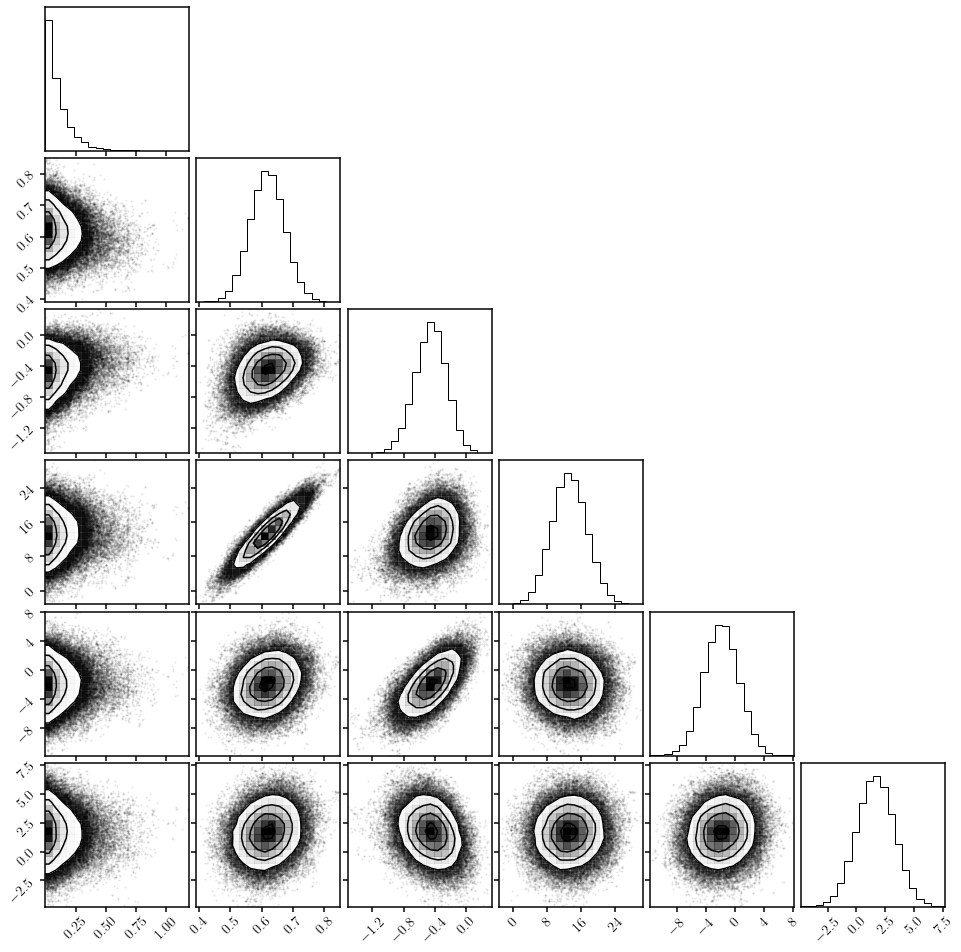

In [96]:
_ = DFM.corner(desi_mcmc._flatten_chain(zeus_chain2[1000:,:,:]))

In [99]:
new_theta_true = theta_true.copy()
new_theta_true[-6:] = np.median(desi_mcmc._flatten_chain(zeus_chain2[1000:,:,:]), axis=0)
new_theta_true

array([ 9.44809328e+00,  5.00000000e-01,  3.50000000e-01,  5.00000000e-02,
        1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  4.50000000e-03,
        2.00000000e-03,  7.27152387e-02,  6.17404172e-01, -4.50343190e-01,
        1.32604319e+01, -1.92056739e+00,  1.64755253e+00])

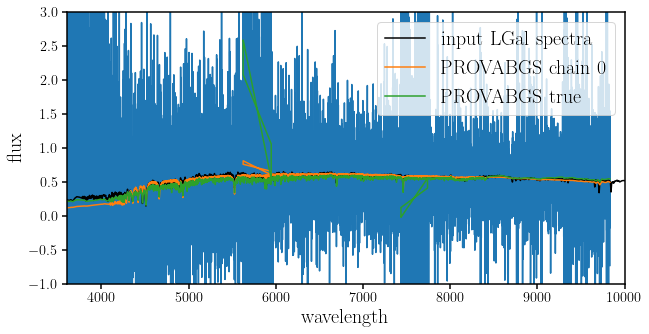

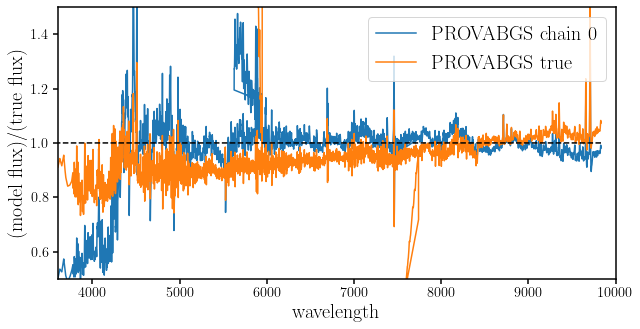

In [108]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k', label='input LGal spectra')
sub.plot(zeus_chain0['wavelength_obs'], zeus_chain0['flux_spec_model'], label='PROVABGS chain 0')
#sub.plot(zeus_chain1['wavelength_obs'], zeus_chain1['flux_spec_model'], label='PROVABGS chain 1')

w, f = m_nmf.sed(new_theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
sub.plot(w, f, label='PROVABGS true')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-1, 3)
sub.legend(loc='upper right', fontsize=20, frameon=True)


fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
#sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
#sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k', label='input LGal spectra')
sub.plot(zeus_chain0['wavelength_obs'], zeus_chain0['flux_spec_model']/np.interp(zeus_chain0['wavelength_obs'], spec_nonoise['wave'], spec_nonoise['flux'][igal,:]), label='PROVABGS chain 0')
#sub.plot(zeus_chain1['wavelength_obs'], zeus_chain1['flux_spec_model']/np.interp(zeus_chain1['wavelength_obs'], spec_nonoise['wave'], spec_nonoise['flux'][igal,:]), label='PROVABGS chain 1')

w, f = m_nmf.sed(new_theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
sub.plot(w, f/np.interp(w, spec_nonoise['wave'], spec_nonoise['flux'][igal,:]), label='PROVABGS true')
sub.plot(w, np.ones(len(w)), c='k', ls='--')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('(model flux)/(true flux)', fontsize=20)
sub.set_ylim(0.5, 1.5)
sub.legend(loc='upper right', fontsize=20, frameon=True)

In [107]:
print(np.sum((spec_noise['flux'][igal,:] -zeus_chain0['flux_spec_model'])**2*spec_noise['ivar'][igal,:]))

w, f = m_nmf.sed(theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
print(np.sum((spec_noise['flux'][igal,:] - f)**2*spec_noise['ivar'][igal,:]))

w, f = m_nmf.sed(new_theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
print(np.sum((spec_noise['flux'][igal,:] - f)**2*spec_noise['ivar'][igal,:]))

8790.322198551425
9116.390505389456
8949.550840104543


/Users/chahah/projects/provabgs/src/provabgs/models.py:875: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
